In [40]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import keras as ks
from ucimlrepo import fetch_ucirepo 

from keras.models import Sequential
from keras.layers import Dense, Activation   
from keras.datasets import mnist, fashion_mnist
from keras.layers import Input, Dense, Conv2D, Dropout, Flatten, MaxPooling2D, LSTM, Embedding

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import accuracy_score, confusion_matrix,  classification_report
from sklearn.datasets import load_iris, load_digits, fetch_20newsgroups_vectorized, fetch_olivetti_faces

# Lecture 10 (Neural Networks)

## The gradient descent

Consider the following problem: we have a multivariable function $F(x_1,\ldots,x_n)$ that we want to optimize, i.e. find the point at which $F$ attains its minimum or maximum. There is an iterative algorithm called [steepest descent algorithm](https://ocw.mit.edu/courses/mathematics/18-409-topics-in-theoretical-computer-science-an-algorithmists-toolkit-fall-2009/lecture-notes/MIT18_409F09_scribe21.pdf) similar to Newton-Raphson that we can use to find this point. The algorithm uses the [gradient](https://inst.eecs.berkeley.edu/~ee127/sp21/livebook/def_gradient.html) of the function. Recall that the gradient $\nabla F$ at a point $x$ 

$$ \nabla F = \left(\frac{\partial F}{\partial x_1},\ldots,\frac{\partial F}{\partial x_n}\right) $$

gives us the direction at which $F$ has the largest (in absolute value) derivative. The algorithm uses this information and iteratively pushes an initial guess into better and better approximations of the optimum point. Let us start with an initial guess $x^{(0)} = (x_1^{(0)},\ldots,x_n^{(0)})$ for $F(x_1^{(0)},\ldots,x_n^{(0)}) = c$, and move in the direction of the gradient with a small step (called **learning rate**). Then the update rule for the path we are going to follow is

$$ x^{(m+1)} = x^{(m)} - \eta \left(\nabla F\right)(x_1^{(m)},\ldots,x_n^{(m)}) $$

where $\eta$ is called *the learning rate*. 

Now, let us solve $ f(x) = c $ using gradient descent. The following function is minimized at $f(x)=c$. So,

$$ F(x) = \frac{1}{2} (f(x) - c)^2 \quad \Rightarrow \quad \nabla F(x) = (f(x)-c) \nabla f(x) $$

So this update rule is:
$$ x^{(k+1)} = x^{(k)} - \eta (f(x^{(k)}) - c) \nabla f(x^{(k)}) $$


In [234]:
def MSolve(f, c, x0, lr=0.01, h=1e-5, tol=1e-5, n=15000):
    x0 = np.array(x0, dtype=float)
    dim = len(x0)
    
    def numerical_grad(f, x):
        grad = np.zeros_like(x)
        for i in range(len(x)):
            dx = np.zeros_like(x)
            dx[i] = h
            grad[i] = (f(x + dx) - f(x - dx)) / (2 * h)
        return grad

    for i in range(n):
        fx = f(x0)
        grad_f = numerical_grad(f, x0)
        x1 = x0 - lr * (fx - c) * grad_f
        if np.linalg.norm(x1 - x0) < tol:
            break
        x0 = x1
    return [i, x1]

Let us solve a specific example. Let $f(x,y) = x^2 + 3y^2$, let $c=0$, let initial point $(x_0,y_0)=(2,2)$ and let us set the learning rate at 0.01

In [235]:
def f(x):
    return x[0]**2 + 3 * x[1]**2

MSolve(f, c=0.0, x0=[2.0, 2.0], lr=1e-2)

[3952, array([7.93556903e-02, 1.49809119e-05])]

We started at the point $(2, 2)$ with the learning rate at set 0.01.  The red dots show the successive steps taken by the algorithm as it descends toward the minimum at the origin $(0, 0)$. This function is **convex**. The descent follows an **elliptical path**, with rapid convergence in $y$ and slower motion in $x$. The gradient is $ \nabla f(x, y) = (2x, 6y) $. So, the updates are:

$$ x^{(n+1)} = x^{(n)} - 0.01 \cdot 2x^{(n)},\quad y^{(n+1)} = y^{(n)} - 0.01 \cdot 6y^{(n)} $$

<img width="500px" src="../images/steepest_descent.png">

## The perceptron


Perceptrons are the main building blocks of artificial neural networks. They are designed to solve binary classification problems. They take a collection of input values $x = (x_1,\ldots,x_n)$ apply a linear combination 

$$\alpha\cdot x + \beta = a_1 x_1 + \cdots + a_n x_n + \beta$$ 

using a collection of weights $\alpha = (a_0,\ldots,a_n)$ and $\beta$ to be determined via an iterative approach. Then we apply an activation function $\varphi(x)$ to get an output which is either 0 or 1.

![Perceptron](../images/perceptron.gif)

([Source: Multilayer perceptrons from "Nonlinear Switching State-Space Models" by Antti Honkela](https://users.ics.aalto.fi/ahonkela/dippa/node41.html))


This is a generalization of the [logistic regression](https://en.wikipedia.org/wiki/Logistic_regression) algorithm we covered in earlier lectures.  In the logistic regression case $\varphi(x) = \frac{1}{1+e^{-x}}$.  So, if we have a collection of data points $(x^{(i)},y^{(i)})$ that we assume satisfy a relationship of the form

$$ y^{(i)} - \varphi(\alpha\cdot x^{(i)} + \beta) \sim N(0,\sigma) $$

where $\varphi\colon\mathbb{R}\to\mathbb{R}$ is a real valued function of a single variable, $\alpha$ and $x^{(i)}$ are vectors in an inner product space and $\beta$ is a scalar.  Our task is to find the best fitting pair $(\alpha,\beta)$ such that 

$$ \sum_i (y^{(i)} - \varphi(\alpha\cdot x^{(i)} + \beta))^2 $$

is minimized. So, we proceed by an iterative update:

$$ \alpha^{(n+1)} = \alpha^{(n)} - \frac{\eta \delta^{(n)}}{\varphi'(\alpha^{(n)}\cdot x^{(n)}+\beta^{(n)})} x^{(n)} $$

where $\delta^{(n)} = \varphi(\alpha^{(n)}\cdot x^{(n)} + \beta^{(n)}) - y^{(n)}$

### Feed-forward and back-propagation

In the feed-forward stage of the computation, we calculate the output $\varphi(\alpha^{(n)}\cdot x + \beta^{(n)})$. In the back-propagation phase, we calculate the error $y - \varphi(\alpha^{(n)}\cdot x + \beta^{(n)})$ and adjust the weights as described above to obtain the next iteration of weights $(\alpha^{(n+1)},\beta^{(n+1)})$.

### An example

For this example, we are going to use a [toy dataset](http://archive.ics.uci.edu/ml/datasets/connectionist+bench+(sonar,+mines+vs.+rocks)) from UCI: 

In [157]:
sonar = fetch_ucirepo(id=151) 
  
sonar_X = sonar.data.features 
sonar_y_raw = sonar.data.targets 

In [158]:
encoder = LabelBinarizer()
sonar_y = encoder.fit_transform(sonar_y_raw)

In [207]:
def fit_predict(xs, ys, f, f_prime, epochs, track=10, eta=0.1, tol=1e-4):
    # Convert to NumPy arrays and add bias term
    X = np.hstack([np.ones((len(xs), 1)), xs])
    N, d = X.shape
    w = np.random.randn(d)
    errors = []

    for i in range(epochs):
        # Pick a random training sample
        j = np.random.randint(N)

        # Forward pass
        z = np.dot(w, X[j])
        a = f(z)
        delta = a - ys[j]

        # Update rule if error exceeds tolerance
        if abs(delta) > tol:
            grad = delta * f_prime(z) * X[j]
            w -= eta * grad

        # Track training error every 10 steps
        if i % track == 0:
            z_all = X @ w
            y_hat = f(z_all)
            mse = np.mean((y_hat - ys) ** 2)
            errors.append(mse)

    # Final prediction
    y_pred = f(X @ w)
    return y_pred, errors, w


Text(0, 0.5, 'MSE')

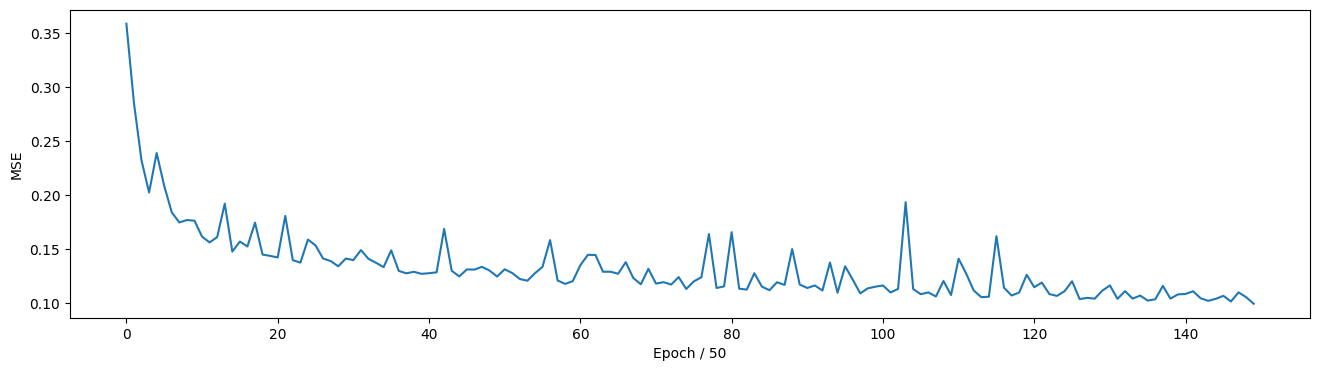

In [299]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def sigmoid_prime(x):
    s = sigmoid(x)
    return s * (1 - s)

# Train
y_pred, errs, weights = fit_predict(sonar_X, sonar_y.reshape(-1), sigmoid, sigmoid_prime, epochs=15000, track=100, eta=0.5, tol=5e-4)

# Plot error
plt.figure(figsize=(16,4))
plt.plot(errs)
plt.xlabel("Epoch / 50")
plt.ylabel("MSE")

In [300]:
def helper(x,th=0.5):
    if x>=th:
        return 1
    else:
        return 0
    
tmp = np.vectorize(helper)(y_pred).reshape(-1)
confusion_matrix(sonar_y,tmp)

array([[105,   6],
       [ 17,  80]])

## Neural networks

While perceptrons are limited in their ability to learn complex non-linear relationships, they can be combined into more sophisticated architectures called [neural networks](https://en.wikipedia.org/wiki/Artificial_neural_network). Another way of saying would be a neural network is a directed computation graph of perceptrons:

![](../images/neural-net.png)

Neural networks are composed of multiple layers of interconnected perceptrons. Thus their weights form a sequence of matrices (a tensor) $(w^i_{j,k})$.  In the feedforward phase of the network,  where the input $(x^i_j)$ at some layer $i$ is processed by the network as

$$ x^{i+1}_k = \sum_j f^i_k(x^i_j w^i_{j,k}) $$

where $f^i_k$ is the activation function at the neuron $k$ at level $i$. Again, as in the case of perceptron, when we get the output from the output layer, we calculate the error and then propagate the error back updating weights iteratively. This procedure is a variation of the gradient descent algorithm we outlined above.

There is a [very large number](http://www.asimovinstitute.org/neural-network-zoo/) of different types of neural networks. Unlike the perceptrons, it is neither practical nor recommended that you implement neural networks by hand. 

![](../images/meme.jpg)

 I would suggest Use one of the following libraries or frameworks: 

1. [TensorFlow](https://www.tensorflow.org/)
2. [PyTorch](https://pytorch.org/)
3. [Keras](https://keras.io/)
4. [MXNet](https://mxnet.apache.org/versions/1.9.1/)


Tensorflow has a very nice [playground](https://playground.tensorflow.org/) where you can experiment with different architectures, activations functions etc. I highly recommend it.

## An example 

All of todays examples are going to use the keras library. Let us start with the first example we used today, the sonar dataset. Let us construct a simple neural-net for binary classification, i.e. a perceptron:

In [48]:
model = Sequential()

model.add(Input(shape=(60,1)))
model.add(Flatten())
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['binary_accuracy'])

X_train, X_test, y_train, y_test = train_test_split(sonar_X,sonar_y,train_size=0.7)

In [51]:
model.fit(X_train, y_train, epochs=500, batch_size=20)

Epoch 1/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - binary_accuracy: 0.8534 - loss: 0.3919 
Epoch 2/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - binary_accuracy: 0.8674 - loss: 0.3943 
Epoch 3/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - binary_accuracy: 0.8442 - loss: 0.4154 
Epoch 4/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - binary_accuracy: 0.8536 - loss: 0.4175 
Epoch 5/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - binary_accuracy: 0.8113 - loss: 0.4405 
Epoch 6/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - binary_accuracy: 0.8360 - loss: 0.3974 
Epoch 7/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - binary_accuracy: 0.8689 - loss: 0.3924 
Epoch 8/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - binary_accuracy: 0.8439 - loss: 0.4140 
Epoch 9/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - binary_accuracy: 0.8705 - loss: 0.4175 
Epoch 10/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - binary_accuracy: 0.8696 - loss: 0.4027 
Epoch 11/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - binary_accuracy: 0.8013 - loss: 0.443

In [50]:
y_predict = model.predict(X_test)
tmp = np.vectorize(lambda x: helper(x,th=0.75))(y_predict.reshape(y_predict.shape[0]))
confusion_matrix(y_test,tmp)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


array([[34,  1],
       [17, 11]])

## Another standard small example



In [80]:
iris = load_iris()
x_iris = iris['data']
y_iris = iris['target']

labeler = LabelBinarizer()
y = labeler.fit_transform(y_iris)
y

array([[1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0,

In [81]:
model = Sequential()

model.add(Input(shape=(4,1)))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(3,activation='sigmoid'))

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['binary_accuracy'])

x_train, x_test, y_train, y_test = train_test_split(x_iris, y)

In [82]:
model.fit(x_train,y_train, epochs=250, batch_size=20)

Epoch 1/250
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - binary_accuracy: 0.6057 - loss: 0.6667
Epoch 2/250
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - binary_accuracy: 0.6694 - loss: 0.6057 
Epoch 3/250
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - binary_accuracy: 0.6993 - loss: 0.5682 
Epoch 4/250
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - binary_accuracy: 0.7718 - loss: 0.5355 
Epoch 5/250
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - binary_accuracy: 0.7750 - loss: 0.4989
Epoch 6/250
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - binary_accuracy: 0.7547 - loss: 0.4817
Epoch 7/250
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - binary_accuracy: 0.7971 - loss: 0.4694 
Epoch 8/250
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - binary_accuracy: 0.8539 - loss: 0.4425 
Epoch 9/250
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - binary_accuracy: 0.8860 - loss: 0.4156 
Epoch 10/250
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - binary_accuracy: 0.8853 - loss: 0.4003 
Epoch 11/250
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - binary_accuracy: 0.8695 - loss: 0.3822

In [83]:
y_pred = model.predict(x_test)
yy_pred = np.argmax(y_pred,axis=1)
yy_test = np.argmax(y_test,axis=1)

print(accuracy_score(yy_test,yy_pred))
confusion_matrix(yy_test,yy_pred)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
0.9473684210526315


array([[14,  0,  0],
       [ 0, 14,  2],
       [ 0,  0,  8]])

In [84]:
np.round(100*y_pred,1)

array([[  0. ,   0. , 100. ],
       [100. ,   0. ,   0. ],
       [  0. ,  99.7,   0.1],
       [  0.4,  99.8,   0. ],
       [  0. ,   0. , 100. ],
       [  0. ,  18.7,  84. ],
       [100. ,   0. ,   0. ],
       [100. ,   0. ,   0. ],
       [100. ,   0. ,   0. ],
       [  0. ,  98. ,   0.8],
       [ 99.6,   0.6,   0. ],
       [  0.1,  99.8,   0. ],
       [100. ,   0. ,   0. ],
       [100. ,   0. ,   0. ],
       [ 99.9,   0.1,   0. ],
       [  0. ,   0. , 100. ],
       [ 99.9,   0.1,   0. ],
       [  0. ,  99.9,   0. ],
       [  0. ,   0.4,  99.9],
       [ 99.9,   0.1,   0. ],
       [  0.1,  99.9,   0. ],
       [  0. ,  99.2,   0.3],
       [100. ,   0. ,   0. ],
       [  0. ,  99.9,   0. ],
       [100. ,   0. ,   0. ],
       [  0.6,  99.7,   0. ],
       [100. ,   0. ,   0. ],
       [  0. ,  81.2,  12.6],
       [  0. ,   0.1, 100. ],
       [100. ,   0. ,   0. ],
       [  0. ,   4.6,  97.4],
       [  0. ,  99.1,   0.3],
       [  0.2,  99.9,   0. ],
       [  

## A Large Example



In [65]:
digits = load_digits()
x_digits = digits['data']
y_digits = digits['target']

labeler = LabelBinarizer()

yy_digits = labeler.fit_transform(y_digits)
xx_digits = x_digits.reshape(1797,8,8,1)

x_train, x_test, y_train, y_test = train_test_split(xx_digits, yy_digits)

model = Sequential()

model.add(Input(shape=(8,8,1)))
model.add(Conv2D(32, (3, 2), padding="same", activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(128, activation = 'relu'))
model.add(Dense(10, activation = 'softmax'))
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['binary_accuracy'])

In [67]:
model.fit(x_train, y_train, batch_size=64, epochs=10)

Epoch 1/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - binary_accuracy: 0.9975 - loss: 0.0183 
Epoch 2/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - binary_accuracy: 0.9966 - loss: 0.0200 
Epoch 3/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - binary_accuracy: 0.9986 - loss: 0.0149 
Epoch 4/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - binary_accuracy: 0.9993 - loss: 0.0127 
Epoch 5/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - binary_accuracy: 0.9988 - loss: 0.0140 
Epoch 6/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - binary_accuracy: 0.9993 - loss: 0.0107 
Epoch 7/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - binary_accuracy: 0.9995 - loss: 0.0103 
Epoch 8/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - binary_accuracy: 0.9993 - loss: 0.0096 
Epoch 9/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - binary_accuracy: 0.9993 - loss: 0.0086 
Epoch 10/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - binary_accuracy: 0.9997 - loss: 0.0071 


In [68]:
y_pred = model.predict(x_test)
yy_pred = np.argmax(y_pred,axis=1)
yy_test = np.argmax(y_test,axis=1)

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step  


In [70]:
print(classification_report(yy_test,yy_pred))
confusion_matrix(yy_test,yy_pred)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        43
           1       0.96      1.00      0.98        50
           2       1.00      1.00      1.00        41
           3       1.00      1.00      1.00        47
           4       1.00      1.00      1.00        39
           5       1.00      1.00      1.00        41
           6       1.00      1.00      1.00        51
           7       0.98      0.96      0.97        48
           8       0.98      0.94      0.96        47
           9       0.98      1.00      0.99        43

    accuracy                           0.99       450
   macro avg       0.99      0.99      0.99       450
weighted avg       0.99      0.99      0.99       450



array([[43,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0, 50,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0, 41,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0, 47,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0, 39,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0, 41,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0, 51,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0, 46,  1,  1],
       [ 0,  2,  0,  0,  0,  0,  0,  1, 44,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0, 43]])

## Yet Another Example


In [71]:
faces = fetch_olivetti_faces(data_home='/home/kaygun/local/data/scikit_learn_data/')
binarizer = LabelBinarizer()

y = binarizer.fit_transform(faces.target.flatten()).reshape(-1,40)
X = faces.data.flatten().reshape(-1,4096)

X_train, X_test, y_train, y_test = train_test_split(X,y, train_size=0.75)

In [74]:
model = Sequential()

model.add(Input(shape=(4096,)))
model.add(Flatten())
model.add(Dense(128, activation="relu",))
model.add(Dense(256, activation = 'relu'))
model.add(Dense(64, activation = 'relu'))
model.add(Dense(40, activation = 'softmax'))

model.compile(optimizer='adam',
              loss='categorical_crossentropy')

model.fit(X_train, y_train, batch_size=64, epochs=500, validation_data=(X_test,y_test))

Epoch 1/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - loss: 3.8238 - val_loss: 3.7896
Epoch 2/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 3.7030 - val_loss: 3.7817
Epoch 3/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 3.6520 - val_loss: 3.7342
Epoch 4/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 3.6428 - val_loss: 3.7029
Epoch 5/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 3.6011 - val_loss: 3.6871
Epoch 6/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 3.5587 - val_loss: 3.6852
Epoch 7/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 3.4955 - val_loss: 3.6371
Epoch 8/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 3.4448 - val_loss: 3.6269
Epoch 9/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 3.3865 - val_loss: 3.5295
Epoch 10/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 3.3029 - val_loss: 3.4962
Epoch 11/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 3.1657 - val_loss: 3.3882
Epoch 12/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 3.1058 - val_lo

In [75]:
y_pred = model.predict(X_test)
yy_pred = np.argmax(y_pred,axis=1)
yy_test = np.argmax(y_test,axis=1)

print(classification_report(yy_test,yy_pred))
print(confusion_matrix(yy_test,yy_pred))

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
              precision    recall  f1-score   support

           0       1.00      0.50      0.67         4
           1       1.00      1.00      1.00         3
           2       1.00      0.75      0.86         4
           3       0.00      0.00      0.00         0
           4       1.00      0.50      0.67         2
           5       0.00      0.00      0.00         0
           6       0.67      1.00      0.80         2
           7       1.00      1.00      1.00         3
           9       1.00      1.00      1.00         2
          10       1.00      1.00      1.00         1
          11       0.50      1.00      0.67         1
          12       0.00      0.00      0.00         1
          13       0.67      1.00      0.80         2
          14       1.00      1.00      1.00         5
          15       0.75      1.00      0.86         3
          16       1.00      1.00      1.00         2
          17       1.00      1.00      1.00

/home/kaygun/.local/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/kaygun/.local/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/kaygun/.local/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/kaygun/.local/lib/python